In [1]:
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import pingouin as pg
import numpy as np
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# считывание данных
df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-romanova-28/statistics/hw_bootstrap.csv", decimal=',', sep=';', index_col=0)

In [4]:
# посмотрим на данные

In [5]:
df

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control
...,...,...
996,1000.000000,Treatment
997,1200.000000,Treatment
998,1500.000000,Treatment
999,2000.000000,Treatment


In [6]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [7]:
df.isna().sum()

value                0
experimentVariant    0
dtype: int64

Сохраним результаты A/B-теста в отдельные таблицы

In [8]:
df_control = df[df.experimentVariant == 'Control']

In [9]:
df_control.shape

(500, 2)

In [10]:
df_treatment = df[df.experimentVariant == 'Treatment']

In [11]:
df_treatment.shape

(500, 2)

Размеры выборок одинаковы. Посмотрим на рапределение выручки в каждом случае

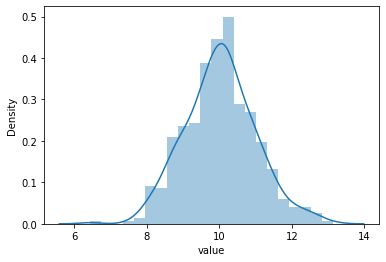

In [12]:
sns.distplot(df_control.value)

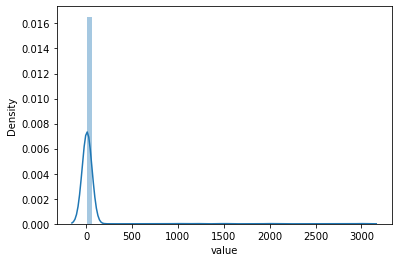

In [13]:
sns.distplot(df_treatment.value)

Посмотрим детальней

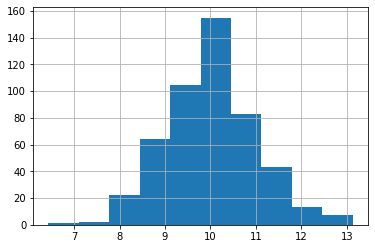

In [14]:
df_treatment[df_treatment.value < 1000].value.hist(bins=10)

В распределении выручки эксперимента treatment есть значительные выбросы

**t-тест**

Для применения t-теста необходимо проверить условия
1. Распределение признаков в каждой выборке соответствует нормальному распределению
2. Дисперсии признака в выборках примерно равны

Также будем сичтать, что предложенные выборки независимы

Нормальность проверим тестом Агостино-Пирсона (он больше адаптирован к большим выборкам) (H0 - распределение нормальное)

In [15]:
ss.normaltest(df_control.value)

NormaltestResult(statistic=2.9434587202565154, pvalue=0.22952820483957936)

In [16]:
ss.normaltest(df_treatment.value)

NormaltestResult(statistic=929.5157667884811, pvalue=1.439513760946726e-202)

Значения control распределены нормально, treatment - нет. Возьмем во внимание, что условие нормальности распределения данных становится не таким жестким при "больших" объемах выборок, и проверим следующее условие тестом Левена (H0 - дисперсии гомогенны)

In [17]:
ss.levene(df_control.value, df_treatment.value)

LeveneResult(statistic=4.297836608151554, pvalue=0.03841703888538016)

Принимаем альтернативную гипотезу - дисперсии гетерогенны (различаются).

Для выборок с разными дисперсиями используем модификацию t-критерия (критерий Уэлча) (H0 - средние не различаются)

In [18]:
stats.ttest_ind(df_control.value, df_treatment.value, equal_var = False)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.03869409943233407)

Значение меньше 0.05, поэтому мы отклоняем нулевую гипотезу и делаем вывод, что средние в группах значимо различаются.

**U-тест**

Условия независимости выборок и возможном ненормальном распределении выборок соблюдены. (H0 - распределение признака в первой выборке соответствует распределению признака во второй выборке)

In [19]:
ss.mannwhitneyu(df_control.value, df_treatment.value)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Значение больше 0.05, поэтому мы принимаем нулевую гипотезу и делаем вывод, что средние в группах не отличаются.

**Бутстрап средних**

In [20]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

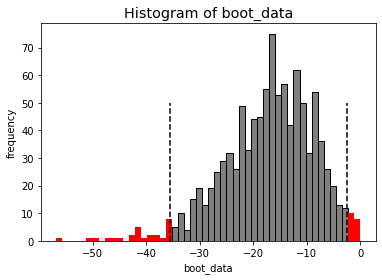

In [21]:
booted_data = get_bootstrap(df_control.value, df_treatment.value)

In [22]:
booted_data["p_value"]

0.0422905483395481

In [23]:
booted_data["quants"]

,0
0.025,-35.522468
0.975,-2.441249


Доверительный интервал в 0 не попадает, значит отклоняем нулевую гипотезу и делаем вывод, что средние в группах значимо различаются.

Три способа определения ответа на вопрос: стали ли мы больше зарабатывать с пользователя или нет, дали различные результаты. t-тест и бустрап средних говорит о том, что результат теста положительный, а U-тест - что средние не отличаются.

Учитывая, что дисперсии гетерогенны, распределение тестовой выборки ненормальное со значительными выбросами, будем ориентироваться на результат U-теста Mann-Whitney и считать, что мы не стали больше зарабатывать с пользователя.